In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr
import os
import category_encoders as ce


# Load data
def get_pandas_frame(path):
    return pyreadr.read_r(path)[None]


def get_pandas_r_file(week_nr, file_type):
    week_nr = str(week_nr)
    week_folder = f"Kickstarter/2019_week{week_nr}"
    pledge_name = os.path.join(week_folder, f"{file_type}.rds")
    return get_pandas_frame(pledge_name)


def select_all_project_id_from_category(df, category):
    """
    take all the project id with the column Category == category
    :param df:
    :param category:
    :return:
    """
    df = df[df["Category"] == category]
    return df["my_id"].unique()

def get_np_array_only_project_id_software_animation_videogames(df_info):
    project_id_software19, project_id_animation19, project_id_videogames19 = [select_all_project_id_from_category(df_info, category) for category in ["Software", "Animation", "Video Games"]]
    return np.concatenate((project_id_software19, project_id_animation19, project_id_videogames19))

def select_dataframes_from_the_available_project_ids(posts_df, all_projects_df, info_df, pledge_df, project_ids):
    """
    select all the posts from the project ids
    :param posts_df:
    :param project_ids:
    :return:
    """
    selected_posts = posts_df[posts_df["Project_my_id"].isin(project_ids)]
    selected_all_projects = all_projects_df[all_projects_df["my_id"].isin(project_ids)]
    selected_info = info_df[info_df["my_id"].isin(project_ids)]
    selected_pledge = pledge_df[pledge_df["Project_my_id"].isin(project_ids)]
    return selected_posts, selected_all_projects, selected_info, selected_pledge

def get_important_posts_animation_videogames_software():


    all_project_week19, info_week19, pledge_week19, posts_week19 = [get_pandas_r_file(19, file_type) for file_type in ["all_projects", "info", "pledge", "posts"]]
    selected_ids = get_np_array_only_project_id_software_animation_videogames(info_week19)
    selected_post19, selected_all_projects19, selected_info19, selected_pledge19 = select_dataframes_from_the_available_project_ids(posts_week19, all_project_week19, info_week19, pledge_week19, selected_ids)
    return selected_post19, selected_all_projects19, selected_info19, selected_pledge19

In [47]:
important_posts, important_all_projects, important_info, important_pledge = get_important_posts_animation_videogames_software()


# Initiate the label column

In [48]:
important_posts["Predicted_Label"] = 3

In [49]:
important_posts.head()

,Project_my_id,creator_slug,project_slug,Post_Nb,Post_Title,Post_Date,Post_Text,Post_id,Predicted_Label
38385,project_005539,damicareer,purpose-connect,Update #2,The WHY...,"Apr 23, 2019",I received this from one of my clients last ye...,project_0055392,3
38386,project_005539,damicareer,purpose-connect,Update #1,Timeline Expectations - Day 2 Update,"Apr 20, 2019","Hey guys, itâs Day 2 and I just want to firs...",project_0055391,3
38387,project_005546,kidunot89,wpgraphql-woocommerce,Update #1,Release v0.0.3-beta,"Apr 25, 2019",Version 0.0.3 was released. Full Changelog...,project_0055461,3
38388,project_005547,465222059,table-university,Update #2,new collaboration started,"Apr 9, 2019",We started a new collaboration with tesilike. ...,project_0055472,3
38389,project_005547,465222059,table-university,Update #1,additional information!,"Apr 5, 2019",Hi all! I would add just an information to be...,project_0055471,3


# Setup the torch device

In [50]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


# Setup the model that is trained on twitter tweets for sentiment

In [15]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)
text = """"I hate your"""
#text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
# # TF
# model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)
# text = "Covid cases are increasing fast!"
# encoded_input = tokenizer(text, return_tensors='tf')
# output = model(encoded_input)
# scores = output[0][0].numpy()
# scores = softmax(scores)
# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")



Some weights of the model checkpoint at twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1) negative 0.914
2) neutral 0.0759
3) positive 0.0101


In [14]:
l = config.id2label[ranking[0]]
s = scores[ranking[0]]
print(l, s)
print(ranking[2])

negative 0.9140185
2


# Predict the labels for the post content

In [67]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
# For every sentence...
for index, row in important_posts.iterrows():
    text = row["Post_Text"]
    text = preprocess(text)

    #encoded_input = tokenizer(text, return_tensors='pt')
    encoded_input = tokenizer.encode_plus(text, return_tensors='pt', max_length=512, truncation=True)
    if len(encoded_input["input_ids"][0]) > 512:
        print("Too long")
        continue

    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    predicted_label = ranking[0]
    important_posts.at[index, "Predicted_Label"] = predicted_label


    #print(f"{text} \n {predicted_label} \n {scores} \n")


# Write out the posts with predicted labels for safety in a csv file

In [83]:
important_posts

,Project_my_id,creator_slug,project_slug,Post_Nb,Post_Title,Post_Date,Post_Text,Post_id,Predicted_Label
38385,project_005539,damicareer,purpose-connect,Update #2,The WHY...,"Apr 23, 2019",I received this from one of my clients last ye...,project_0055392,2
38386,project_005539,damicareer,purpose-connect,Update #1,Timeline Expectations - Day 2 Update,"Apr 20, 2019","Hey guys, itâs Day 2 and I just want to firs...",project_0055391,2
38387,project_005546,kidunot89,wpgraphql-woocommerce,Update #1,Release v0.0.3-beta,"Apr 25, 2019",Version 0.0.3 was released. Full Changelog...,project_0055461,1
38388,project_005547,465222059,table-university,Update #2,new collaboration started,"Apr 9, 2019",We started a new collaboration with tesilike. ...,project_0055472,2
38389,project_005547,465222059,table-university,Update #1,additional information!,"Apr 5, 2019",Hi all! I would add just an information to be...,project_0055471,2
...,...,...,...,...,...,...,...,...,...
377750,project_058917,2079547763,jagged-alliance-flashback,Update #36,Developer Diary 1 on Character Development,"Nov 15, 2013","Dear Backers, Today we have a real treat for ...",project_05891736,2
446816,project_073338,timseastudios,adome-action-platformer-and-exploration-adventure,Update #4,Timsea Studios announcement.,"Apr 26, 2019",In Timsea Studios we have made the decision to...,project_0733384,2
446817,project_073338,timseastudios,adome-action-platformer-and-exploration-adventure,Update #3,Working the art of displacement!,"Apr 22, 2019",In Timsea Studios we are paying special attent...,project_0733383,2
446818,project_073338,timseastudios,adome-action-platformer-and-exploration-adventure,Update #2,Gameplay!,"Apr 18, 2019",Adome gameplay is based on a satisfying sense ...,project_0733382,2


In [68]:
important_posts.to_csv('Data_posts_with_labels_sentiment.csv', index=False)

In [113]:
important_posts.head(10)

,Project_my_id,creator_slug,project_slug,Post_Nb,Post_Title,Post_Date,Post_Text,Post_id,Predicted_Label
38385,project_005539,damicareer,purpose-connect,Update #2,The WHY...,"Apr 23, 2019",I received this from one of my clients last ye...,project_0055392,2
38386,project_005539,damicareer,purpose-connect,Update #1,Timeline Expectations - Day 2 Update,"Apr 20, 2019","Hey guys, itâs Day 2 and I just want to firs...",project_0055391,2
38387,project_005546,kidunot89,wpgraphql-woocommerce,Update #1,Release v0.0.3-beta,"Apr 25, 2019",Version 0.0.3 was released. Full Changelog...,project_0055461,1
38388,project_005547,465222059,table-university,Update #2,new collaboration started,"Apr 9, 2019",We started a new collaboration with tesilike. ...,project_0055472,2
38389,project_005547,465222059,table-university,Update #1,additional information!,"Apr 5, 2019",Hi all! I would add just an information to be...,project_0055471,2
38390,project_005548,182057119,gimli,Update #4,Ionic Framework snippets,"Apr 26, 2019",Playing around with Ionic Framework snippets. ...,project_0055484,1
38391,project_005548,182057119,gimli,Update #3,Silly experiment #2,"Apr 12, 2019",Code at: https://codepen.io/gimli_app/pen/VNW...,project_0055483,1
38392,project_005548,182057119,gimli,Update #2,"Just a silly experiment, about 30 lines of css...","Apr 12, 2019",View code at: https://twitter.com/gimli_app/st...,project_0055482,1
38393,project_005548,182057119,gimli,Update #1,First project update!,"Apr 10, 2019",Check out the medium post below where I will d...,project_0055481,1
38398,project_005560,armandosomoza,codescty-like-schoolhouse-rock-for-computer-sc...,Update #13,"You did it $51,600!! Thank you!!","Apr 22, 2019","!!!!!! Â $51,600 - $51,600 - $51,600 !!!!!!Â ...",project_00556013,2


In [114]:
important_posts[important_posts["Post_Text"] == "ONLY FOR BACKERS"]

,Project_my_id,creator_slug,project_slug,Post_Nb,Post_Title,Post_Date,Post_Text,Post_id,Predicted_Label
38461,project_005566,34257246,create-gui-applications-with-python-wxpython,Update #21,Getting the book,"Apr 16, 2019",ONLY FOR BACKERS,project_00556621,1
38502,project_005571,1100657250,blenderxr-modeling-features-development,Update #2,An early announce for our backers!,"Dec 3, 2018",ONLY FOR BACKERS,project_0055712,1
38508,project_005573,stephenhaney,modulzthe-next-step-in-visual-coding,Update #6,ðModulz Update,"Feb 13, 2019",ONLY FOR BACKERS,project_0055736,1
38511,project_005573,stephenhaney,modulzthe-next-step-in-visual-coding,Update #3,Modulz is #4 on ProductHunt!,"Oct 26, 2018",ONLY FOR BACKERS,project_0055733,1
38516,project_005574,pablofarias,data-science-mini-degree-learn-python-and-data...,Update #7,The Data Science Mini-Degree is READY!,"Dec 6, 2018",ONLY FOR BACKERS,project_0055747,1
...,...,...,...,...,...,...,...,...,...
377732,project_058917,2079547763,jagged-alliance-flashback,Update #54,Good news on the physical rewards!,"Jul 23, 2015",ONLY FOR BACKERS,project_05891754,1
377733,project_058917,2079547763,jagged-alliance-flashback,Update #53,June update - things are moving again!!,"Jun 19, 2015",ONLY FOR BACKERS,project_05891753,1
377734,project_058917,2079547763,jagged-alliance-flashback,Update #52,Quick status update March 2015,"Mar 11, 2015",ONLY FOR BACKERS,project_05891752,1
377735,project_058917,2079547763,jagged-alliance-flashback,Update #51,"THANKS! And more on rewards, mods, updates","Jan 20, 2015",ONLY FOR BACKERS,project_05891751,1


# Create average Post length, total nr of posts, average nr of posts per project

In [126]:
def iterate_over_posts_with_label_and_add_to_info(posts_with_label_df, info_df ):
    """
    iterates over the posts, then for each post it adds the count to the corresponding project id in the info_df
    ::TODO:: make it work with tokens instead of words
    :param posts_with_label_df:
    :param info_df:
    :return:
    """
    info_df["Positive_Post_count"] = 0
    info_df["Negative_Post_count"] = 0
    info_df["Neutral_Post_count"] = 0
    info_df["Total_nr_posts"] = 0
    info_df["total_words_all_posts"] = 0
    info_df["has_only_backers"] = 0
    i = 0
    for index, row in posts_with_label_df.iterrows():
        i+=1
        project_id = row["Project_my_id"]
        post_text = row["Post_Text"]
        label = row["Predicted_Label"]
        if 'ONLY FOR BACKERS' in post_text:
            info_df.loc[info_df["my_id"] == project_id, "has_only_backers"] = 1
        info_df.loc[info_df["my_id"] == project_id, "Total_nr_posts"] += 1
        info_df.loc[info_df["my_id"] == project_id, "total_words_all_posts"] += len(post_text.split())

        if label == 2:
            info_df.loc[info_df["my_id"] == project_id, "Positive_Post_count"] += 1
        elif label == 0:
            info_df.loc[info_df["my_id"] == project_id, "Negative_Post_count"] += 1
        elif label == 1:
            info_df.loc[info_df["my_id"] == project_id, "Neutral_Post_count"] += 1
        if i % 100 == 0:
            print(i)
    return info_df

#important_info_new = iterate_over_posts_with_label_and_add_to_info(merged_posts_df, important_info)
important_info_new = iterate_over_posts_with_label_and_add_to_info(important_posts, important_info)
important_info_new

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

,my_id,creator_slug,project_slug,Blurb,Category,Location,Staff_recommended,Goal_USD,Pledge_USD,Number_Backers,...,Positive_Post_count,Negative_Post_count,Neutral_Post_count,Total_nr_posts,total_words_all_posts,has_only_backers,Positive_Post_percentage,Negative_Post_percentage,Neutral_Post_percentage,average_words_posts
5538,project_005539,damicareer,purpose-connect,A job match engine that is non-resume based,Software,Springfield | US,FALSE,10000,37,5,...,2,0,0,2,601,0,1.00,0.0,0.00,300.50
5539,project_005540,carnostic,carnostic-your-car-is-talking-to-you-listen,Using Artificial Intelligence to provide all d...,Software,Toronto | CA,FALSE,18717.74475,7166.1185259291,31,...,0,0,0,0,0,0,0.00,0.0,0.00,0.00
5540,project_005541,bharatbhardwaj,bugs-utf8-email,Email service for internationalized domain nam...,Software,Los Angeles | US,FALSE,33666,11,2,...,0,0,0,0,0,0,0.00,0.0,0.00,0.00
5541,project_005542,sacoconnect,saco-innovative-contact-management-software,The first automated contact information manage...,Software,Mexico City | MX,FALSE,159943.71,51.651155416,2,...,0,0,0,0,0,0,0.00,0.0,0.00,0.00
5542,project_005543,hlx,zentail-to-newegg-integration,Zentail to NewEgg software integration,Software,Brooklyn | US,FALSE,5000,11,2,...,0,0,0,0,0,0,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59202,project_058915,432712414,ar-k-an-old-school-game-with-a-new-twist,"Filled with mystery, humor, and suspense, and ...",Video Games,Corunna | ES,TRUE,1e+05,101564.23,879,...,13,0,7,20,4581,1,0.65,0.0,0.35,229.05
59203,project_058916,tripleslash,magnetic-by-nature,Wield the power of magnetism on a journey thro...,Video Games,Salt Lake City | US,FALSE,10000,11285.02,416,...,1,0,19,20,143,1,0.05,0.0,0.95,7.15
59204,project_058917,2079547763,jagged-alliance-flashback,The Godfather of turn-based RPG action is maki...,Video Games,Copenhagen | DK,TRUE,350000,368614.44,7167,...,12,0,8,20,12183,1,0.60,0.0,0.40,609.15
73697,project_073338,timseastudios,adome-action-platformer-and-exploration-adventure,"ADOME is an action, platformer and first-perso...",Video Games,Murcia | ES,FALSE,50000,1343,38,...,3,0,1,4,1627,0,0.75,0.0,0.25,406.75


# make an average post percentage

In [127]:
def turn_positive_post_count_into_percentage(info_df):
    """
    turns the positive post count into a percentage
    also it turns the NaN values of the proportion into a 0
    also turns_tokens_all_posts into an an average tokens per post
    :param info_df:
    :return:
    """
    for index, row in info_df.iterrows():
        if row["Total_nr_posts"] == 0:
            info_df.loc[index, "Positive_Post_percentage"] = 0
            info_df.loc[index, "Negative_Post_percentage"] = 0
            info_df.loc[index, "Neutral_Post_percentage"] = 0
            info_df.loc[index, "average_words_posts"] = 0
        else:
            info_df.loc[index, "Positive_Post_percentage"] = row["Positive_Post_count"] / row["Total_nr_posts"]
            info_df.loc[index, "Negative_Post_percentage"] = row["Negative_Post_count"] / row["Total_nr_posts"]
            info_df.loc[index, "Neutral_Post_percentage"] = row["Neutral_Post_count"] / row["Total_nr_posts"]
            info_df.loc[index, "average_words_posts"] = row["total_words_all_posts"] / row["Total_nr_posts"]


    return info_df.drop(columns=["total_words_all_posts"])

important_info_new = turn_positive_post_count_into_percentage(important_info_new)
important_info_new

,my_id,creator_slug,project_slug,Blurb,Category,Location,Staff_recommended,Goal_USD,Pledge_USD,Number_Backers,...,Project_description,Positive_Post_count,Negative_Post_count,Neutral_Post_count,Total_nr_posts,has_only_backers,Positive_Post_percentage,Negative_Post_percentage,Neutral_Post_percentage,average_words_posts
5538,project_005539,damicareer,purpose-connect,A job match engine that is non-resume based,Software,Springfield | US,FALSE,10000,37,5,...,"For the past couple of years, DAMI Career and ...",2,0,0,2,0,1.00,0.0,0.00,300.50
5539,project_005540,carnostic,carnostic-your-car-is-talking-to-you-listen,Using Artificial Intelligence to provide all d...,Software,Toronto | CA,FALSE,18717.74475,7166.1185259291,31,...,You'll need an HTML5 capable browser to see th...,0,0,0,0,0,0.00,0.0,0.00,0.00
5540,project_005541,bharatbhardwaj,bugs-utf8-email,Email service for internationalized domain nam...,Software,Los Angeles | US,FALSE,33666,11,2,...,à¤¸à¤¬ à¤à¥à¤ #à¤¹à¤¿à¤à¤¦à¥à¤®à¥à¤ à¤ ...,0,0,0,0,0,0.00,0.0,0.00,0.00
5541,project_005542,sacoconnect,saco-innovative-contact-management-software,The first automated contact information manage...,Software,Mexico City | MX,FALSE,159943.71,51.651155416,2,...,Our story: We (the owners) own a couple of c...,0,0,0,0,0,0.00,0.0,0.00,0.00
5542,project_005543,hlx,zentail-to-newegg-integration,Zentail to NewEgg software integration,Software,Brooklyn | US,FALSE,5000,11,2,...,"If you are in eCommerce, you know the perks of...",0,0,0,0,0,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59202,project_058915,432712414,ar-k-an-old-school-game-with-a-new-twist,"Filled with mystery, humor, and suspense, and ...",Video Games,Corunna | ES,TRUE,1e+05,101564.23,879,...,Check out the Updates #16 and #17 for the ...,13,0,7,20,1,0.65,0.0,0.35,229.05
59203,project_058916,tripleslash,magnetic-by-nature,Wield the power of magnetism on a journey thro...,Video Games,Salt Lake City | US,FALSE,10000,11285.02,416,...,"""It's like Limbo, but with magnets!"" - Kotak...",1,0,19,20,1,0.05,0.0,0.95,7.15
59204,project_058917,2079547763,jagged-alliance-flashback,The Godfather of turn-based RPG action is maki...,Video Games,Copenhagen | DK,TRUE,350000,368614.44,7167,...,We would like to thank all the backers for mak...,12,0,8,20,1,0.60,0.0,0.40,609.15
73697,project_073338,timseastudios,adome-action-platformer-and-exploration-adventure,"ADOME is an action, platformer and first-perso...",Video Games,Murcia | ES,FALSE,50000,1343,38,...,This campaign is also available in Â Spanish ...,3,0,1,4,0,0.75,0.0,0.25,406.75


# Take only important columns

In [128]:
def take_useful_columns_from_dataframe(df):
    """
    takes the columns that are useful for the model
    :param df:
    :return:
    """
    return df[['Category', 'Goal_USD', 'Pledge_USD', 'Project_nb_updates', 'Location', 'Number_Backers', 'Creator_nb_projects', 'has_only_backers',"Total_nr_posts", "Positive_Post_count","Neutral_Post_count","Negative_Post_count", "Positive_Post_percentage", "Negative_Post_percentage", "Neutral_Post_percentage", "average_words_posts"]]
important_info_new = take_useful_columns_from_dataframe(important_info_new)

# Remove missing values

In [121]:
def remove_missing_values(df_combine):
    df_combine_cleaned = df_combine.dropna()

    return df_combine_cleaned
important_info_new = remove_missing_values(important_info_new)

# Encoding the labels and the categorical variables

In [130]:
def encoding(df_combine_cleaned):
    df_combine_cleaned.loc[:, 'has_only_backers'] = np.where(df_combine_cleaned['has_only_backers'] == True, 1, 0)

    df_combine_cleaned.loc[:, 'Goal_USD'] = df_combine_cleaned['Goal_USD'].astype('float')
    df_combine_cleaned['Pledge_USD'] = pd.to_numeric(df_combine_cleaned['Pledge_USD'], errors='coerce')
    df_combine_cleaned.loc[:, 'has_reached_goal'] = np.where(df_combine_cleaned['Goal_USD'] <= df_combine_cleaned['Pledge_USD'], 1, 0)

    df_combine_cleaned.loc[:, 'Total_nr_posts'] = df_combine_cleaned['Total_nr_posts'].fillna(0)
    location_split = df_combine_cleaned ['Location'].str.split(' \| ', expand=True)
    df_combine_cleaned ['Country'] = location_split[1]
    #encoder = ce.BinaryEncoder(cols=['Country'])
    #df_combine_cleaned = encoder.fit_transform(df_combine_cleaned)
    df_combine_cleaned = pd.get_dummies(df_combine_cleaned, columns=['Country'], prefix='Country')
    for col in df_combine_cleaned.columns:
        if 'Country_' in col:  # or any other prefix you have used
            df_combine_cleaned[col] = df_combine_cleaned[col].astype(int)

    df_combine_cleaned = pd.get_dummies(df_combine_cleaned, prefix=["Cat"], columns=['Category'])
    df_combine_cleaned["Cat_Animation"] = df_combine_cleaned["Cat_Animation"].astype(int)
    df_combine_cleaned["Cat_Video Games"] = df_combine_cleaned["Cat_Video Games"].astype(int)
    df_combine_cleaned["Cat_Software"] = df_combine_cleaned["Cat_Software"].astype(int)

    #encoder = ce.BinaryEncoder(cols=['Category'])
    #df_combine_cleaned = encoder.fit_transform(df_combine_cleaned)
    df_combine_encoded = df_combine_cleaned

    return df_combine_encoded
important_info_new = encoding(important_info_new)
important_info_new

/var/folders/f3/ykt1vfz96xz48try_trwdn440000gn/T/ipykernel_23850/3365103014.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combine_cleaned['Pledge_USD'] = pd.to_numeric(df_combine_cleaned['Pledge_USD'], errors='coerce')
/var/folders/f3/ykt1vfz96xz48try_trwdn440000gn/T/ipykernel_23850/3365103014.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combine_cleaned.loc[:, 'has_reached_goal'] = np.where(df_combine_cleaned['Goal_USD'] <= df_combine_cleaned['Pledge_USD'], 1, 0)
/var/folders/f3/ykt1vfz96

,Goal_USD,Pledge_USD,Project_nb_updates,Location,Number_Backers,Creator_nb_projects,has_only_backers,Total_nr_posts,Positive_Post_count,Neutral_Post_count,...,Country_TW,Country_UA,Country_US,Country_VE,Country_VN,Country_ZA,Country_ZM,Cat_Animation,Cat_Software,Cat_Video Games
5538,10000.0,37.000000,2,Springfield | US,5,1,0,2,2,0,...,0,0,1,0,0,0,0,0,1,0
5539,18717.74475,7166.118526,0,Toronto | CA,31,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5540,33666.0,11.000000,0,Los Angeles | US,2,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
5541,159943.71,51.651155,0,Mexico City | MX,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5542,5000.0,11.000000,0,Brooklyn | US,2,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59202,100000.0,101564.230000,44,Corunna | ES,879,3,1,20,13,7,...,0,0,0,0,0,0,0,0,0,1
59203,10000.0,11285.020000,45,Salt Lake City | US,416,1,1,20,1,19,...,0,0,1,0,0,0,0,0,0,1
59204,350000.0,368614.440000,55,Copenhagen | DK,7167,1,1,20,12,8,...,0,0,0,0,0,0,0,0,0,1
73697,50000.0,1343.000000,4,Murcia | ES,38,1,0,4,3,1,...,0,0,0,0,0,0,0,0,0,1


In [131]:
def to_num(df_combine_encoded):
    # Dropping the 'Project_nb_updates' and 'Location' columns
    df_combine_encoded = df_combine_encoded.drop(['Project_nb_updates', 'Location'], axis=1)

    # Converting 'has_only_backers' to numeric
    df_combine_encoded['has_only_backers'] = pd.to_numeric(df_combine_encoded['has_only_backers'], errors='coerce')
    df_combine_encoded['Goal_USD'] = pd.to_numeric(df_combine_encoded['Goal_USD'], errors='coerce')
    df_combine_encoded['Creator_nb_projects'] = pd.to_numeric(df_combine_encoded['Creator_nb_projects'], errors='coerce')

    df_combine_ready = df_combine_encoded

    return df_combine_ready
important_info_new = to_num(important_info_new)

In [132]:
important_info_new


,Goal_USD,Pledge_USD,Number_Backers,Creator_nb_projects,has_only_backers,Total_nr_posts,Positive_Post_count,Neutral_Post_count,Negative_Post_count,Positive_Post_percentage,...,Country_TW,Country_UA,Country_US,Country_VE,Country_VN,Country_ZA,Country_ZM,Cat_Animation,Cat_Software,Cat_Video Games
5538,10000.00000,37.000000,5,1.0,0,2,2,0,0,1.00,...,0,0,1,0,0,0,0,0,1,0
5539,18717.74475,7166.118526,31,1.0,0,0,0,0,0,0.00,...,0,0,0,0,0,0,0,0,1,0
5540,33666.00000,11.000000,2,1.0,0,0,0,0,0,0.00,...,0,0,1,0,0,0,0,0,1,0
5541,159943.71000,51.651155,2,1.0,0,0,0,0,0,0.00,...,0,0,0,0,0,0,0,0,1,0
5542,5000.00000,11.000000,2,1.0,0,0,0,0,0,0.00,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59202,100000.00000,101564.230000,879,3.0,1,20,13,7,0,0.65,...,0,0,0,0,0,0,0,0,0,1
59203,10000.00000,11285.020000,416,1.0,1,20,1,19,0,0.05,...,0,0,1,0,0,0,0,0,0,1
59204,350000.00000,368614.440000,7167,1.0,1,20,12,8,0,0.60,...,0,0,0,0,0,0,0,0,0,1
73697,50000.00000,1343.000000,38,1.0,0,4,3,1,0,0.75,...,0,0,0,0,0,0,0,0,0,1


# Write the created dataframe to a csv file

In [133]:
important_info_new.to_csv('Data_with_labels_sentiment_final.csv', index=False)

In [85]:
count_has_only_backers = important_info_new["has_only_backers"].value_counts()
count_has_not_only_backers = important_info_new["has_only_backers"].value_counts()

In [94]:
count_has_only_backers

has_only_backers
0    4216
1    1577
Name: count, dtype: int64

/var/folders/f3/ykt1vfz96xz48try_trwdn440000gn/T/ipykernel_23850/2886949425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=important_info_new.has_only_backers, palette='gray')


[Text(0.5, 1.0, 'Projects that have posts with only backers'),
 Text(0, 0.5, 'Number of Posts'),
 Text(0.5, 0, '0 = for all,  1= has only for backers posts')]

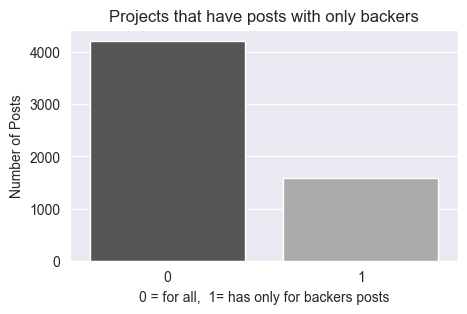

In [93]:
#make a plot with the number of posts that have only backers compared to where it is 0
plt.figure(figsize=(5, 3))
sns.countplot(x=important_info_new.has_only_backers, palette='gray')
plt.gca().set(title='Projects that have posts with only backers', ylabel="Number of Projects", xlabel='0 = for all,  1= has only for backers posts')

/var/folders/f3/ykt1vfz96xz48try_trwdn440000gn/T/ipykernel_23850/2436478492.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=count_has_only_backers, palette='gray')


[Text(0.5, 1.0, 'Positive Kickstarter posts | Gaming, Art, Software'),
 Text(0, 0.5, 'Number of Posts'),
 Text(0.5, 0, '0 = Negative,  1= Neutral, 2= Positive')]

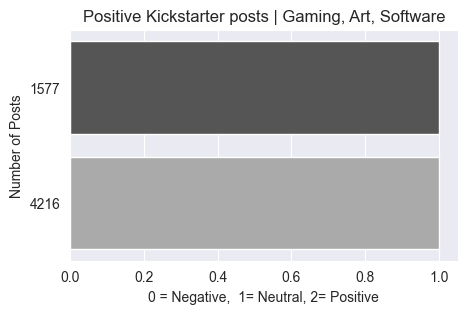

In [88]:
plt.figure(figsize=(5, 3))
sns.countplot(x=count_has_only_backers, palette='gray')
plt.gca().set(title='Positive Kickstarter posts | Gaming, Art, Software', ylabel="Number of Posts", xlabel='0 = Negative,  1= Neutral, 2= Positive')


In [92]:
important_posts.Predicted_Label

38385     2
38386     2
38387     1
38388     2
38389     2
         ..
377750    2
446816    2
446817    2
446818    2
446819    1
Name: Predicted_Label, Length: 40953, dtype: int64

/var/folders/f3/ykt1vfz96xz48try_trwdn440000gn/T/ipykernel_23850/1046454318.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=important_posts.Predicted_Label, palette='gray')


[Text(0.5, 1.0, 'Positive Kickstarter posts | Gaming, Art, Software'),
 Text(0, 0.5, 'Number of Posts'),
 Text(0.5, 0, '0 = Negative,  1= Neutral, 2= Positive')]

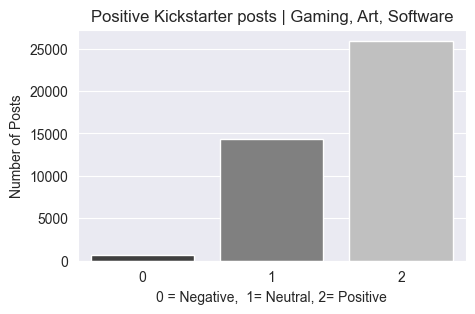

In [87]:
plt.figure(figsize=(5, 3))
sns.countplot(x=important_posts.Predicted_Label, palette='gray')
plt.gca().set(title='Positive Kickstarter posts | Gaming, Art, Software', ylabel="Number of Posts", xlabel='0 = Negative,  1= Neutral, 2= Positive')


In [134]:
important_posts["Predicted_Label"].value_counts()

Predicted_Label
2    25935
1    14344
0      674
Name: count, dtype: int64

In [135]:
important_posts["Predicted_Label"]

38385     2
38386     2
38387     1
38388     2
38389     2
         ..
377750    2
446816    2
446817    2
446818    2
446819    1
Name: Predicted_Label, Length: 40953, dtype: int64